# Zeeman effect of hydrogen-like atomic ground states

(c) Ted Corcovilos 2019-2023

Example calculation of Zeeman effect for the hydrogen ground state, including hyperfine effects.

(TODO: This was copied from the hyperfine version. I didn't rename I to L, and I hacked the version of the hf operator)

(This version is for deuterium).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

%matplotlib inline
np.set_printoptions(precision=3, floatmode='maxprec')
#assuming atomic units throughout unless specified

In [2]:
# set colors for plots
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']


In [3]:
#constants (atomic units unless specified)
alpha=1./137.; # fine structure constant
mp = 1836.; # proton mass
muB = 0.5; #Bohr magneton
muN = muB/mp; #nuclear magneton
mu0 = 4*np.pi*alpha**2; #permeability of vacuum
gs = 2.0; # electron spin gyromagnetic ratio
psi0 = 1/np.sqrt(np.pi); #value of wavefunction at origin
h = 4.136e-15; #Planck's constant in eV s
EH = 27.2; #Hartree energy in eV
B0 = 2.35e5; #atomic unit of magnetic field in T

In [4]:
# Properties of this atom (deuterium)
S=1/2; I=1 #I=1/2;
n_level=2 #principle quantum number
gN = 0.859 #5.59;# nuclear gyromagnetic ratio (depends on atom and isotope)

#hyperfine amplitude coefficient (depends on atom and state)
A_hf = 2*mu0/3*gs*muB*gN*muN*psi0**2 # McIntyre Eq. 11.10
r_minus3_ev = 1/(n_level**3*I*(I+0.5)*(I+1))
A = alpha**2/2*r_minus3_ev
#A = 7.025e-8/2 # for the K-39 problem
print(f"A = {A:.2e} (a.u.) = {A*EH/h/1e6:.2f} MHz") # display A in MHz to compare with McIntyre Fig. 11.4

A = 1.11e-06 (a.u.) = 7299.72 MHz


In [5]:
#degeneracy of S and I.
#Must round so that these are stored as integers (the extra 0.2 is to ensure the rounding goes to the right number)
degS = np.int32(2*S+1.2); degI = np.int32(2*I+1.2); 

In [6]:
#create lists of possible Sz, Iz values in decreasing order
Szlist = np.arange(S,-S-1,-1);
Izlist = np.arange(I,-I-1,-1);

In [7]:
#Generating the individual spin matrices in the uncoupled basis
S2 = S*(S+1)*np.matrix(np.eye(degS)); #S-squared matrix
I2 = I*(I+1)*np.matrix(np.eye(degI)); #I-squared matrix
Sz = np.matrix(np.diag(Szlist)); #Sz matrix
Iz = np.matrix(np.diag(Izlist)); #Iz matrix

In [8]:
# list of the basis state  labels |Sz,Iz>
basislist = np.column_stack((np.diagonal(np.kron(Sz,np.eye(degI))),np.diagonal(np.kron(np.eye(degS),Iz)))); 

In [9]:
print(basislist) # display the row labels, (Sz, Iz) basis

[[ 0.5  1. ]
 [ 0.5  0. ]
 [ 0.5 -1. ]
 [-0.5  1. ]
 [-0.5  0. ]
 [-0.5 -1. ]]


In [10]:
# Generate other spin matrices
Sp=np.matrix(np.diag(np.sqrt(S*(S+1)-(Szlist*(Szlist+1))[1:]),1)); #S+ ladder matrix
Ip=np.matrix(np.diag(np.sqrt(I*(I+1)-(Izlist*(Izlist+1))[1:]),1)); #I+ ladder matrix
Sm=Sp.H; #S- ladder matrix
Im=Ip.H; #I- ladder matrix
Sx=(Sp+Sm)/2;
Ix=(Ip+Im)/2;
Sy=(Sp-Sm)/(0.+2j); #Sy matrix ("j" is sqrt(-1))
Iy=(Ip-Im)/(0.+2j);

The next cell builds the matrices for the Hamiltonian operators.

Being explicit with the tensor products, the hyperfine energy operator is
$$
\begin{aligned}
\hat{H}_\textrm{HF} &= A\,\hat{\mathbf{S}}\cdot\hat{\mathbf{I}} = A\,(\hat{\mathbf{S}}\otimes\hat{1}_I)\cdot(\hat{1}_S\otimes\hat{\mathbf{I}})\\
&= A \Bigl(\hat{S}_z\otimes\hat{I}_z +\tfrac12 (\hat{S}_+\otimes\hat{I}_- +\hat{S}_-\otimes\hat{I}_+)\Bigr),
\end{aligned}
$$
and the Zeeman energy operator is
$$
\hat{H}_\textrm{Z} = B(g_s \mu_B \hat{S}_z\otimes\hat{1}_I + g_N \mu_N \hat{1}_S\otimes\hat{I}_z),
$$
where the identity operators in the corresponding space are represented by $\hat{1}_{S}$ and $\hat{1}_{I}$.

The tensor products are implemented using the numpy `kron` function (Kroenecker product).

In [26]:
# next steps: build hyperfine operator matrix and zeeman operator matrix
# We are assuming l=0 states here (otherwise HF is more complicated)

# hyperfine operator = A*(S dot I)
HF = A*(np.kron(Sz,Iz)+0.5*(np.kron(Sm,Ip)+np.kron(Sp,Im)));
# Zeeman operator, except for the magnetic field magnitude
#ZnoB_hf = gs*muB*np.kron(Sz,np.eye(degI))+gN*muN*np.kron(np.eye(degS),Iz); #multiply this by B to get the Zeeman operator
ZnoB = gs*muB*np.kron(Sz,np.eye(degI))+muB*np.kron(np.eye(degS),Iz); #multiply this by B to get the Zeeman operator
# magnetic field magnitude in atomic units:
B=0; # Change this value to test different magnetic field strengths
# Total hamiltonian
H = HF+B*ZnoB;

In [27]:
# print the Hamiltonian matrix
print(H)

[[ 5.550e-07  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00]
 [ 0.000e+00  0.000e+00  0.000e+00  7.849e-07  0.000e+00  0.000e+00]
 [ 0.000e+00  0.000e+00 -5.550e-07  0.000e+00  7.849e-07  0.000e+00]
 [ 0.000e+00  7.849e-07  0.000e+00 -5.550e-07  0.000e+00  0.000e+00]
 [ 0.000e+00  0.000e+00  7.849e-07  0.000e+00  0.000e+00  0.000e+00]
 [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  5.550e-07]]


In [28]:
#calculate and display the eigenvalues and eigenstates of H for this value of B
evs, ess = np.linalg.eigh(H) 
print(f"The eigenvalues are {evs}.")
print(f"The eigenvectors are the columns of the matrix:\n{ess}.")

The eigenvalues are [-1.11e-06 -1.11e-06  5.55e-07  5.55e-07  5.55e-07  5.55e-07].
The eigenvectors are the columns of the matrix:
[[ 0.    -0.     1.     0.     0.     0.   ]
 [ 0.577 -0.     0.     0.     0.    -0.816]
 [ 0.     0.816  0.     0.    -0.577  0.   ]
 [-0.816  0.     0.     0.     0.    -0.577]
 [ 0.    -0.577  0.     0.    -0.816  0.   ]
 [ 0.     0.     0.     1.     0.     0.   ]].


In [29]:
# maximum frequency splitting in MHz
(max(evs)-min(evs))*EH/h/1e6 

np.float64(10949.574965839902)

In [64]:
# Generate data for the plots by stepping through B values.
Bmin = 0; # minimum B in atomic units
Bmax = 12e-6; # maximum B in atomic units
Bsteps = 101 # number of steps
Blist = np.linspace(Bmin, Bmax, Bsteps) # generate list of B values to evaluate
Elist = []; #empty list to store energy eigenvalues
for B in Blist:
    H = HF+B*ZnoB;
    evs, ess = np.linalg.eigh(H)
    Elist.append(np.sort(evs))
Earray = np.array(Elist)

The perturbation theory solution for weak B field for hydrogen is
$$
\begin{aligned}
E_{F=1, m_F} &\approx \frac{A}{4} + \frac12 (g_s \mu_B + g_N \mu_n)m_F B \\
E_{F=0, m_F=0} & \approx -\frac{3A}{4}
\end{aligned}
$$

In [65]:
# hydrogen weak field PT (manual entry from pen-and-paper calculations)
#Ew_HF = np.array([-0.75*A, A/4., A/4., A/4.]) # hydrogen hf energies
#Ew_ZnoB = np.array([0.,1.,0.,-1.])*(gs*muB+gN*muN)/2. # hydrogen weak Zeeman
Ew_HF = np.array([-A,-A,A/2,A/2,A/2,A/2]) # deuterium hf energies
g_Fhalf = (gs-4*gN/mp)/3.
g_F3half = (gs+2*gN/mp)/3.
Ew_ZnoB = np.array([0.5*g_Fhalf*muB,-0.5*g_Fhalf*muB,1.5*g_F3half*muB,0.5*g_F3half*muB,-0.5*g_F3half*muB,-1.5*g_F3half*muB]) # deuterium weak Zeeman
Ew_list = [];
for B in Blist:
    H = Ew_HF+B*Ew_ZnoB;
    Ew_list.append(H)
Ew_array = np.array(Ew_list)
colors_Ew = [colors[1],colors[0],colors[5],colors[4],colors[3],colors[2]] # manually set plot colors

The perturbation theory solution for strong B field is
$$
\begin{aligned}
E_{m_s, m_I} &\approx m_s m_I A + (g_s \mu_B m_s + g_N \mu_n m_I)B
\end{aligned}
$$

In [66]:
# hydrogen strong field perturbation theory solution
ms = basislist[:,0];
mI = basislist[:,1];
Es_HF = A*ms*mI;
Es_ZnoB = gs*muB*ms+gN*muN*mI;
Es_list=[];
for B in Blist:
    H = Es_HF+B*Es_ZnoB;
    #H = np.array([Ht[2],Ht[3],Ht[1],Ht[0]])
    Es_list.append(H)
Es_array = np.array(Es_list)
colors_Es = [colors[5],colors[4],colors[3],colors[0],colors[1],colors[2]] # manually set plot colors

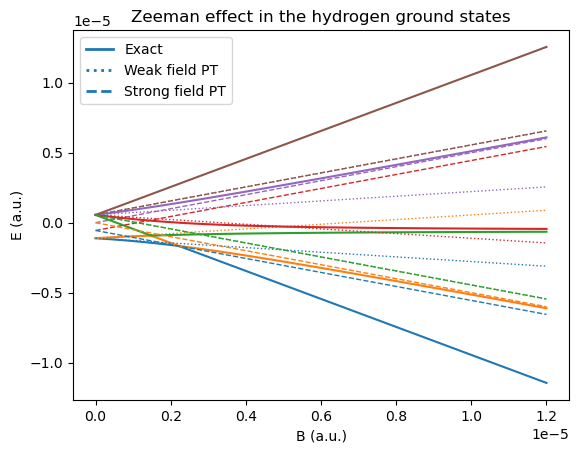

In [67]:
# plot the energy correction as a function of magnetic field amplitude
# If you want to do atoms other than hydrogen, comment out the two lines labeled "hydrogen PT" below.
for x in range(degS*degI):
    plt.plot(np.array(Blist), Earray[:,x], color=colors[x], linestyle='-')
    plt.plot(np.array(Blist), Ew_array[:,x], color=colors_Ew[x], linestyle=':', lw=1) # hydrogen PT weak
    plt.plot(np.array(Blist), Es_array[:,x], color=colors_Es[x], linestyle='--', lw=1) # hydrogen PT strong
plt.xlabel("B (a.u.)");
plt.ylabel("E (a.u.)");
plt.title("Zeeman effect in the hydrogen ground states");
# generate useful legend for the plot
custom_lines = [Line2D([0], [0], color=colors[0], lw=2, linestyle='-'),
                Line2D([0], [0], color=colors[0], lw=2, linestyle=':'),
                Line2D([0], [0], color=colors[0], lw=2, linestyle='--')]
plt.legend(custom_lines, ['Exact', 'Weak field PT', 'Strong field PT'])
#plt.xlim(0,1e-7); plt.ylim(-5e-8,5e-8)
#plt.savefig("Zeeman-D-all.pdf")

[]

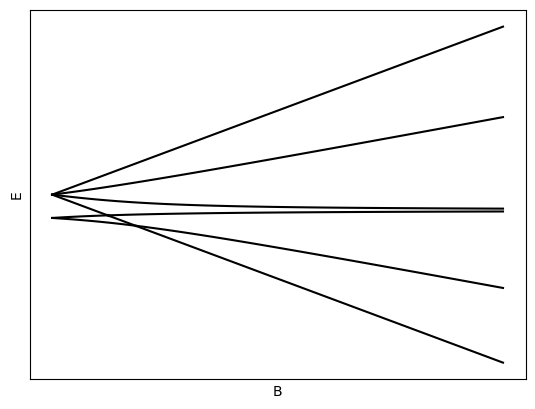

In [68]:
for x in range(degS*degI):
    plt.plot(np.array(Blist), Earray[:,x],'k')
plt.xlabel("B");
plt.ylabel("E");
#plt.title("Zeeman effect in the hydrogen ground states (atomic units)");
#plt.savefig("Zeeman-D-SI.pdf")
plt.gca().axes.get_xaxis().set_ticks([])
plt.gca().axes.get_yaxis().set_ticks([])
plt.savefig(

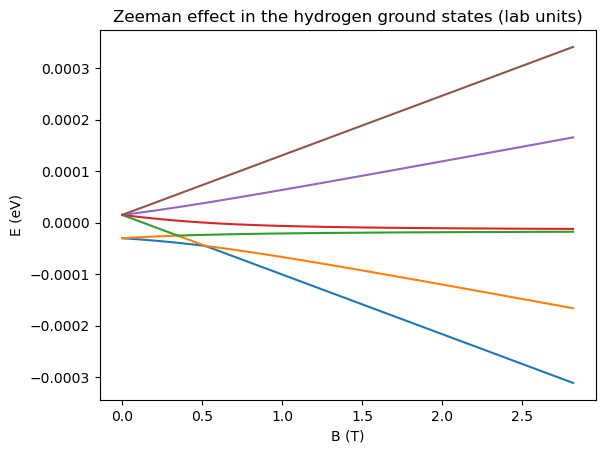

In [69]:
for x in range(degS*degI):
    plt.plot(np.array(Blist)*B0, Earray[:,x]*EH) # convert units to T and eV
plt.xlabel("B (T)");
plt.ylabel("E (eV)");
plt.title("Zeeman effect in the hydrogen ground states (lab units)");
#plt.savefig("Zeeman-D-au.pdf")